## Classificational Cellular Automata

This implementation uses:

1. A grid of cells, where each cell contains a classifier.
2. Energy levels to represent classifier performance.
3. Transaction rules to update energy and replace poor-performing classifiers.

## Explanation of the Implementation

### Classifier Pool:

The pool contains diverse classifiers (decision trees with varying depths).


### CCA Lattice:

The lattice is a 2D grid where each cell holds a classifier and has an associated energy level.


### Transaction Rules:

Increase Energy: When the classifier correctly predicts, boosted by neighborhood support.
Decrease Energy: Penalized for incorrect predictions.
Decay: Energy decreases over time, mimicking resource consumption.

### Cell Replacement:

Cells with low energy are replaced by new classifiers from the pool, maintaining diversity.
Inference:

Each cell votes on the prediction for a test sample.
The final class is determined by a weighted majority vote.


In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Generate synthetic data
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the pool of classifiers
def create_classifier_pool(n_classifiers, max_depth_range=(1, 5)):
    classifiers = []
    for _ in range(n_classifiers):
        max_depth = np.random.randint(max_depth_range[0], max_depth_range[1])
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X_train, y_train)
        classifiers.append(clf)
    return classifiers

# Initialize the CCA lattice
def initialize_cca_grid(size, classifiers):
    grid = np.random.choice(classifiers, size=(size, size))
    energy = np.full((size, size), 100)  # Initial energy level
    return grid, energy

# Update cell energy based on transaction rules
def update_energy(grid, energy, X_sample, y_sample, neighborhood_radius=1):
    size = grid.shape[0]
    new_energy = energy.copy()

    for i in range(size):
        for j in range(size):
            # Get classifier and predict
            clf = grid[i, j]
            pred = clf.predict([X_sample])[0]

            # Neighborhood influence
            neighbors = []
            for di in range(-neighborhood_radius, neighborhood_radius + 1):
                for dj in range(-neighborhood_radius, neighborhood_radius + 1):
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = (i + di) % size, (j + dj) % size
                    neighbors.append(grid[ni, nj].predict([X_sample])[0])

            # Apply transaction rules
            if pred == y_sample:
                score = sum(1 for n in neighbors if n == y_sample)  # Supportive neighbors
                new_energy[i, j] += 10 + score  # Reward correct prediction
            else:
                new_energy[i, j] -= 20  # Penalize incorrect prediction

            # Decay energy over time
            new_energy[i, j] -= 1

    return new_energy

# Replace cells with low energy
def replace_low_energy_cells(grid, energy, classifiers, threshold=10):
    size = grid.shape[0]
    for i in range(size):
        for j in range(size):
            if energy[i, j] < threshold:
                grid[i, j] = np.random.choice(classifiers)  # Replace with a new classifier
                energy[i, j] = 100  # Reset energy
    return grid, energy

# Training the CCA
def train_cca(grid, energy, classifiers, X_train, y_train, iterations=100):
    for _ in range(iterations):
        for X_sample, y_sample in zip(X_train, y_train):
            energy = update_energy(grid, energy, X_sample, y_sample)
            grid, energy = replace_low_energy_cells(grid, energy, classifiers)
    return grid

# Inference with the CCA
def predict_cca(grid, X_test):
    size = grid.shape[0]
    predictions = []

    for X_sample in X_test:
        votes = np.zeros(np.max(y_train) + 1)  # Voting array
        for i in range(size):
            for j in range(size):
                clf = grid[i, j]
                pred = clf.predict([X_sample])[0]
                votes[pred] += 1  # Weighted voting by energy
        predictions.append(np.argmax(votes))  # Choose majority vote
    return predictions

# Main program
n_classifiers = 50
size = 5
classifiers = create_classifier_pool(n_classifiers)
grid, energy = initialize_cca_grid(size, classifiers)

# Train the CCA
trained_grid = train_cca(grid, energy, classifiers, X_train, y_train)

# Test the CCA
predictions = predict_cca(trained_grid, X_test)
accuracy = np.mean(predictions == y_test)
print(f"CCA Accuracy: {accuracy:.2f}")


CCA Accuracy: 1.00


A result of 1.0 in the context of the CCA implementation suggests that the model achieved 100% accuracy on the test set. This means all predictions made by the CCA were correct and matched the true labels of the test samples.

In [3]:
from sklearn.model_selection import cross_val_score

# Use classifiers from the pool
scores = [cross_val_score(clf, X, y, cv=5).mean() for clf in create_classifier_pool(10)]
print(f"Average cross-validated accuracy of base classifiers: {np.mean(scores):.2f}")

Average cross-validated accuracy of base classifiers: 0.81


## Explanation of the Dynamic Plot

### Average Energy Levels:

Tracks the mean energy of all cells at each iteration.
Indicates how well the classifiers are performing collectively (high energy = good performance).

### Training Accuracy:

Tracks the training accuracy at each iteration.
Shows how well the CCA is adapting to the dataset over time.

### Dynamic Visualization:

The setup_dynamic_plot function initializes the plot.
The update_plot function updates it with new data points after every iteration.
The plot dynamically updates in real-time as the training progresses.
Benefits
Helps monitor the training process visually.
Identifies issues such as plateauing accuracy or declining energy levels.
Enhances understanding of how the CCA evolves over iterations.

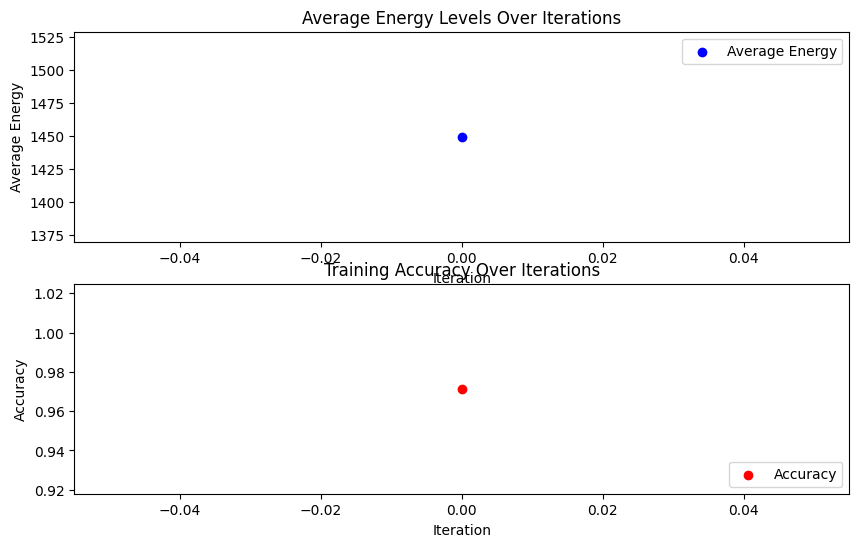

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Generate synthetic data
data = load_iris()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the pool of classifiers
def create_classifier_pool(n_classifiers, max_depth_range=(1, 5)):
    classifiers = []
    for _ in range(n_classifiers):
        max_depth = np.random.randint(max_depth_range[0], max_depth_range[1])
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X_train, y_train)
        classifiers.append(clf)
    return classifiers

# Initialize the CCA lattice
def initialize_cca_grid(size, classifiers):
    grid = np.random.choice(classifiers, size=(size, size))
    energy = np.full((size, size), 100)  # Initial energy level
    return grid, energy

# Update cell energy based on transaction rules
def update_energy(grid, energy, X_sample, y_sample, neighborhood_radius=1):
    size = grid.shape[0]
    new_energy = energy.copy()

    for i in range(size):
        for j in range(size):
            # Get classifier and predict
            clf = grid[i, j]
            pred = clf.predict([X_sample])[0]

            # Neighborhood influence
            neighbors = []
            for di in range(-neighborhood_radius, neighborhood_radius + 1):
                for dj in range(-neighborhood_radius, neighborhood_radius + 1):
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = (i + di) % size, (j + dj) % size
                    neighbors.append(grid[ni, nj].predict([X_sample])[0])

            # Apply transaction rules
            if pred == y_sample:
                score = sum(1 for n in neighbors if n == y_sample)  # Supportive neighbors
                new_energy[i, j] += 10 + score  # Reward correct prediction
            else:
                new_energy[i, j] -= 20  # Penalize incorrect prediction

            # Decay energy over time
            new_energy[i, j] -= 1

    return new_energy

# Replace cells with low energy
def replace_low_energy_cells(grid, energy, classifiers, threshold=10):
    size = grid.shape[0]
    for i in range(size):
        for j in range(size):
            if energy[i, j] < threshold:
                grid[i, j] = np.random.choice(classifiers)  # Replace with a new classifier
                energy[i, j] = 100  # Reset energy
    return grid, energy

# Dynamic plot setup
def setup_dynamic_plot():
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].set_title("Average Energy Levels Over Iterations")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Average Energy")
    ax[1].set_title("Training Accuracy Over Iterations")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Accuracy")
    return fig, ax

# Update the plot dynamically
def update_plot(fig, ax, iteration, avg_energy, accuracy):
    ax[0].scatter(iteration, avg_energy, color="blue", label="Average Energy" if iteration == 0 else "")
    ax[1].scatter(iteration, accuracy, color="red", label="Accuracy" if iteration == 0 else "")
    ax[0].legend(loc="upper right")
    ax[1].legend(loc="lower right")
    plt.pause(0.1)

# Training the CCA
def train_cca(grid, energy, classifiers, X_train, y_train, iterations=100):
    fig, ax = setup_dynamic_plot()
    accuracies = []
    avg_energies = []

    for iteration in range(iterations):
        correct_predictions = 0
        total_samples = len(X_train)

        for X_sample, y_sample in zip(X_train, y_train):
            energy = update_energy(grid, energy, X_sample, y_sample)
            grid, energy = replace_low_energy_cells(grid, energy, classifiers)

            # Check accuracy for dynamic plot
            pred = predict_cca_sample(grid, X_sample)
            if pred == y_sample:
                correct_predictions += 1

        # Calculate metrics for the current iteration
        accuracy = correct_predictions / total_samples
        avg_energy = np.mean(energy)

        accuracies.append(accuracy)
        avg_energies.append(avg_energy)

        # Update the dynamic plot
        update_plot(fig, ax, iteration, avg_energy, accuracy)

    plt.ioff()  # Turn off interactive mode
    plt.show()
    return grid, accuracies, avg_energies

# Predict for a single sample using CCA
def predict_cca_sample(grid, X_sample):
    size = grid.shape[0]
    votes = np.zeros(np.max(y_train) + 1)  # Voting array
    for i in range(size):
        for j in range(size):
            clf = grid[i, j]
            pred = clf.predict([X_sample])[0]
            votes[pred] += 1  # Weighted voting by energy
    return np.argmax(votes)  # Majority vote

# Main program
n_classifiers = 50
size = 5
classifiers = create_classifier_pool(n_classifiers)
grid, energy = initialize_cca_grid(size, classifiers)

# Train the CCA
trained_grid, accuracies, avg_energies = train_cca(grid, energy, classifiers, X_train, y_train, iterations=50)
